In [1]:
%reload_ext tensorboard
%reload_ext autoreload

# Variational Autoencoder

In [2]:
import os
import time
import math
import torch
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.distributions as tdist

from joblib import dump, load
from sklearn.decomposition import PCA
from pdmtut.core import GenerativeModel
from pytorch_lightning import loggers as pl_loggers
from regilib.core.distributions import MultivariateNormal

In [3]:
store_results = True
load_models = True

## Introduction

## Implementation

In [4]:
class VariationalAutoencoder(pl.LightningModule, GenerativeModel):
    class Encoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.enc1 = nn.Linear(3, 64)
            self.encbn1 = nn.BatchNorm1d(num_features=64)
            self.enc2 = nn.Linear(64, 128)
            self.encbn2 = nn.BatchNorm1d(num_features=128)
            self.enc3 = nn.Linear(128, 128)
            self.encbn3 = nn.BatchNorm1d(num_features=128)
            
            # μ
            self.mu_enc4 = nn.Linear(128, 64)
            self.mu_enc5 = nn.Linear(64, 2)
            
            # log σ
            self.log_var_enc4 = nn.Linear(128, 64)
            self.log_var_enc5 = nn.Linear(64, 2)

        def forward(self, z):
            x = F.elu(self.encbn1(self.enc1(z)))
            x = F.elu(self.encbn2(self.enc2(x)))
            x = F.elu(self.encbn3(self.enc3(x)))
            
            # μ
            mu = F.elu(self.mu_enc4(x))
            mu = self.mu_enc5(mu)

            # log σ
            log_var = F.elu(self.log_var_enc4(x))
            log_var = self.log_var_enc5(log_var)
            
            return mu, log_var

    class Decoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.dec1 = nn.Linear(2, 64)
            self.decbn1 = nn.BatchNorm1d(num_features=64)
            self.dec2 = nn.Linear(64, 128)
            self.decbn2 = nn.BatchNorm1d(num_features=128)
            self.dec3 = nn.Linear(128, 128)
            self.decbn3 = nn.BatchNorm1d(num_features=128)
            self.dec4 = nn.Linear(128, 64)
            self.dec5 = nn.Linear(64, 3)

        def forward(self, z):
            x = F.elu(self.decbn1(self.dec1(z)))
            x = F.elu(self.decbn2(self.dec2(x)))
            x = F.elu(self.decbn3(self.dec3(x)))
            x = F.elu(self.dec4(x))
            x = self.dec5(x)
            return x
    
    def __init__(self, noise_std):
        super().__init__()
        self.encoder = VariationalAutoencoder.Encoder()
        self.decoder = VariationalAutoencoder.Decoder()
        self._n_components = 2

        self.noise_dist = MultivariateNormal(
            torch.tensor([0., 0., 0.]), noise_std * torch.eye(3, 3))

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, sample=False):
        mu, log_var = self.encoder(x)

        if not sample: z = mu
        else: z = self.reparameterize(mu, log_var)

        x_reconst = self.decoder(z)
        return x_reconst, mu, log_var
    
    def fit_model(self, X, X_val=None, path=None):
        start_time = time.time()
        
        if path is None:
            tb_logger = False
            checkpoint_callback=False
        else:
            tb_logger = pl_loggers.TensorBoardLogger(path, version=0)
            checkpoint_callback=True
        
        trainer = pl.Trainer(
            max_epochs=2000, gpus=1, logger=tb_logger,
            checkpoint_callback=checkpoint_callback
        )
        trainer.fit(
            self, train_dataloaders=X, val_dataloaders=X_val)
        elapsed_time = time.time() - start_time
        
        if path is not None: 
            with open(os.path.join(path, 'training_time.txt'), 'w') as f:
                f.write(str(elapsed_time))

    def encode(self, X):
        mu, log_var = self.encoder(X)
        return mu.detach().cpu()

    def decode(self, z):
        return self.decoder(z).detach().cpu()
    
    def save(self, path):
        torch.save(self, os.path.join(path, 'model.pt'))
    
    def load(path):
        return torch.load(os.path.join(path, 'model.pt'))
            
    def save_exists(path):
        return (
            os.path.isfile(os.path.join(path, 'model.pt')))

    def log_likelihood(self, X):
        X_rec, mu, log_var = self(X)

        return self.log_prob(X, X_rec, mu, log_var).detach().cpu()

    def sample_posterior(self, n_samples):
        z = torch.randn(n_samples, 2)
        return model.decoder(z).detach().cpu()

    def log_prob(self, x, x_reconst, mu, log_var):
        # dist(0, sigma).log_prob(x - y) <=> dist(y).log_prob(x) but much faster
        reconstruction_log_likelihood = self.noise_dist.log_prob(x_reconst - x)

        # -KL
        kl_div = 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), 1)

        # log p(x|z) - KL(q(z|x), p(z))
        log_likelihood_lb = (reconstruction_log_likelihood + kl_div)

        # log likelihood lower bound
        return log_likelihood_lb

    def training_step(self, batch, batch_idx):
        batch = batch[0]

        x_reconst, mu, log_var = self(batch, sample=True)

        neg_log_likelihood_ub = - self.log_prob(
            batch, x_reconst, mu, log_var).mean()

        self.log('train_loss', neg_log_likelihood_ub)
        return {'loss': neg_log_likelihood_ub}
    
    def validation_step(self, batch, batch_idx):
        batch = batch[0]

        x_reconst, mu, log_var = self(batch, sample=True)

        neg_log_likelihood_ub = - self.log_prob(
            batch, x_reconst, mu, log_var).mean()

        self.log('validation_loss', neg_log_likelihood_ub)
        return {'val_loss': neg_log_likelihood_ub}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return {
            'optimizer': optimizer,
            'lr_scheduler':
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, min_lr=1e-8, factor=0.5, verbose=True,
                patience=100
            ), 'monitor': 'train_loss'
        }

    def __str__(self):
        return 'vae'

## Experiment 1: swiss roll

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/vae'

if store_results:
    result_save_path = '../results/swiss_roll/vae'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and VariationalAutoencoder.save_exists(model_save_path):
    model = VariationalAutoencoder.load(model_save_path)
else:
    model = VariationalAutoencoder(noise_std=1e-2)
    model.fit_model(
        X=dataset.train_loader(batch_size=512),
        X_val=dataset.validation_loader(batch_size=512),
        path=result_save_path)
    
    if store_results:
        model.save(model_save_path)
        
model = model.eval()

In [8]:
%tensorboard --logdir ../results/swiss_roll/vae

### Input Representation

In [9]:
from pdmtut.vis import plot_representation

In [10]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)

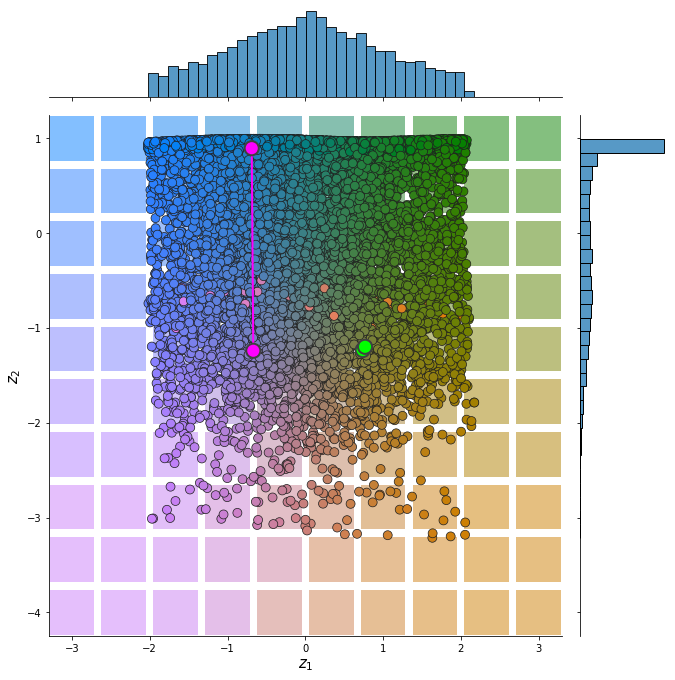

In [11]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [12]:
from pdmtut.vis import plot_reconstruction

In [13]:
z = model.encode(dataset.X)
x = model.decode(z)

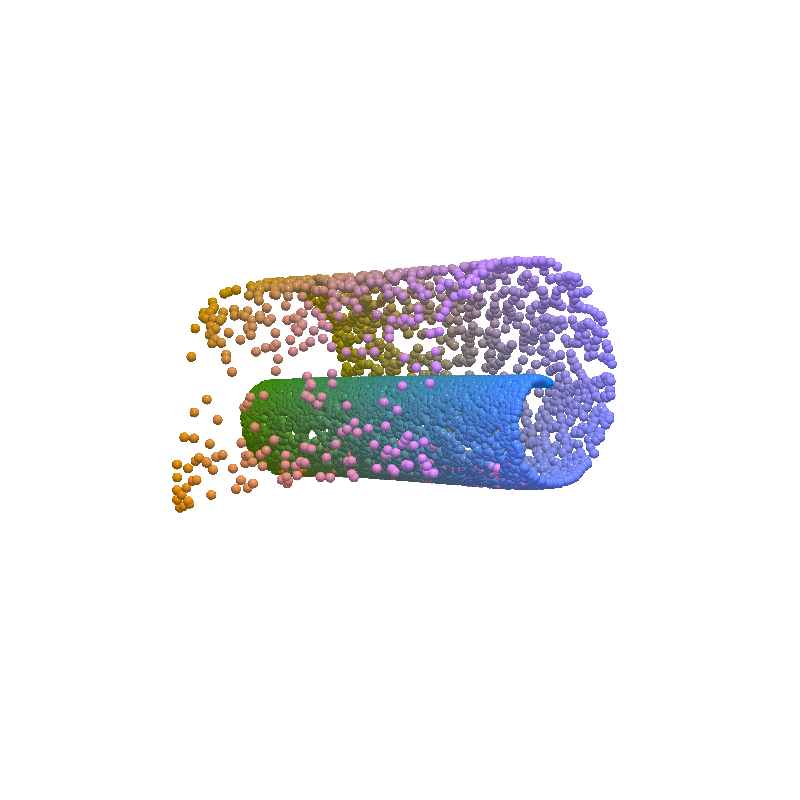

In [14]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

### Density Estimation

In [15]:
from pdmtut.vis import plot_density

In [16]:
log_likelihood = model.log_likelihood(dataset.X)

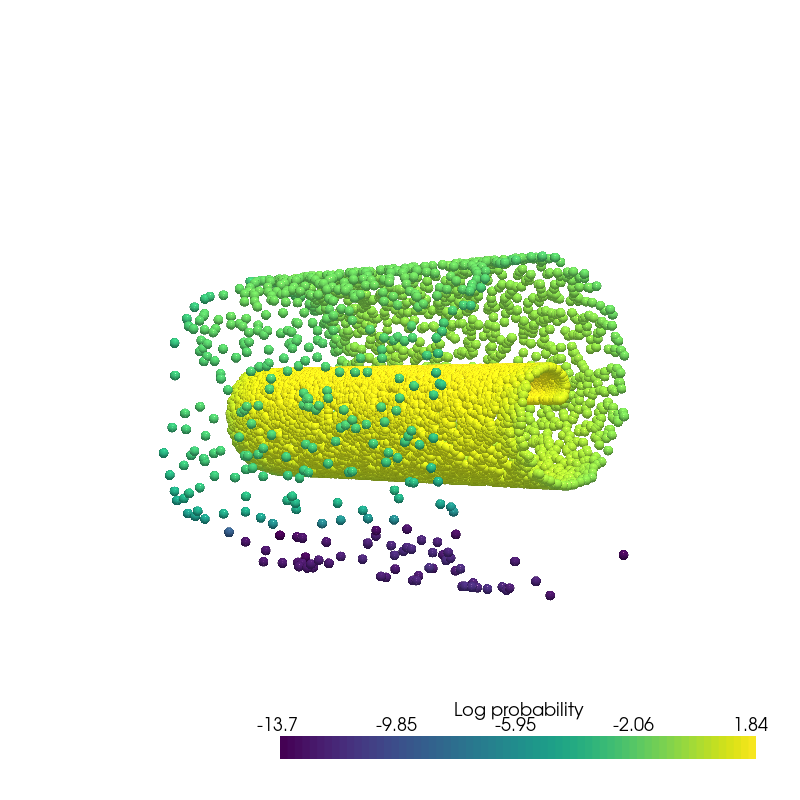

In [17]:
plot_density(dataset.unnormalise_scale(dataset.X).numpy(), log_likelihood.numpy(), root=result_save_path)

### Generate Samples

In [18]:
from pdmtut.vis import plot_generated_samples

In [19]:
generated_samples = model.sample_posterior(100**2)
generated_samples_log_likelihood = model.log_likelihood(generated_samples)

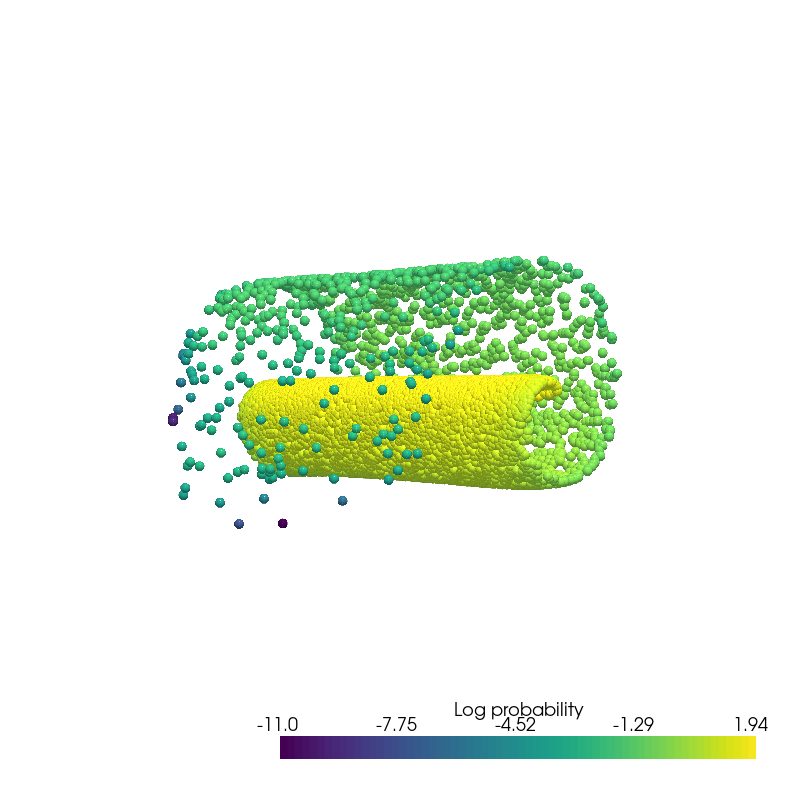

In [20]:
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy(), root=result_save_path)

### Interpolation

In [21]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [22]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))

/home/bawaw/.conda/envs/pdm_tutorial_2/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


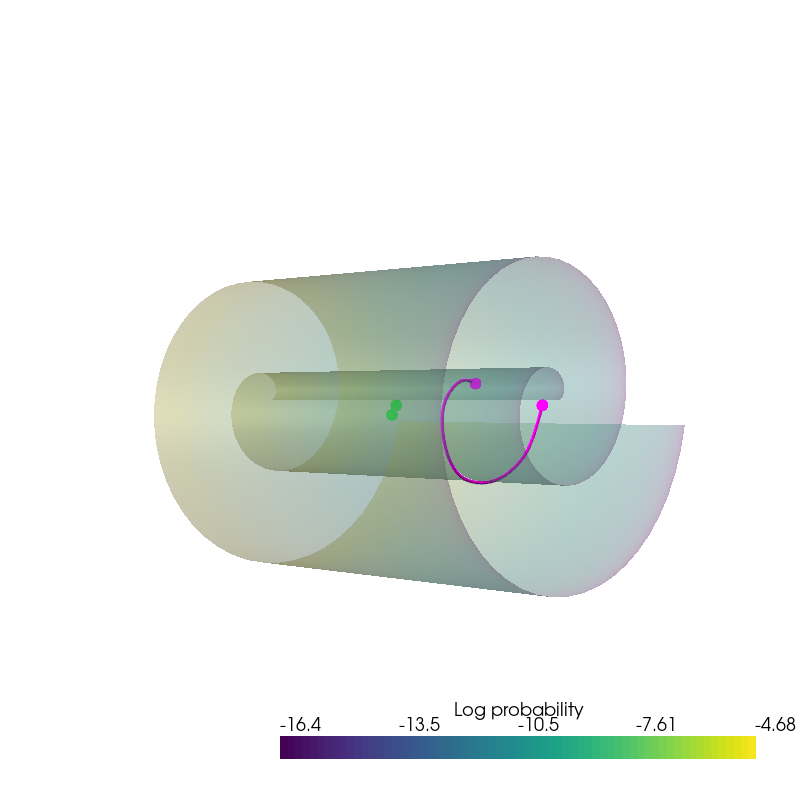

In [23]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)